In [1]:
# Importing Packages and Libraries
import shap
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.pipeline import Pipeline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# 1. Feature Preperation

In [2]:
# Load data
file_path = '/Users/paulahofmann/Documents/Coding/Online-Review/FeaturePreperation/Data_with_Features/Final Data/Hedonic_Final_Cleaned.csv'
df = pd.read_csv(file_path)

In [3]:
# Create a new column 'helpful' based on reviews being helfpul or not helpful
df['helpful'] = (df['helpful_ratio'] > 0).astype(int)

In [4]:
# Define features and target variable
features = ['RewExt','Sentiment','Subjective', 'WordC', 'SentC', 'SentL', 'TitleL', 'ElapDays',
            'Image', 'VerPur', 'NounR', 'AdjR', 'AdvR', 'FRE', 'Prod']
target = 'helpful'


In [5]:
# Define categorical and numerical features
categorical_features = ['Prod']
numerical_features = ['RewExt','Sentiment','Subjective', 'WordC', 'SentC', 'SentL', 'TitleL', 'ElapDays',
            'Image', 'VerPur', 'NounR', 'AdjR', 'AdvR', 'FRE']

# Convert 'product' column to categorical type
df['Prod'] = df['Prod'].astype('category')

# Initialize X and y
X = df[features]
y = df[target]

# Initialize ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), categorical_features),  # One-hot encode 'product'
        ("num", MinMaxScaler(), numerical_features),     # Scale numerical features
    ]
)

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(X)

# Retrieve column names for the one-hot encoded features
cat_column_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine column names for the transformed features
all_column_names = np.concatenate([cat_column_names, numerical_features])

# Convert the transformed data back to a DataFrame
X = pd.DataFrame(X_preprocessed, columns=all_column_names)

# 2 Train/Test Split with Stratified K-Fold Cross-validation for Unbalanced Dataset

In [6]:
from sklearn.model_selection import StratifiedKFold

# Create a combined column for stratification
df['stratify'] = df['helpful'].astype(str) + "_" + df['Prod'].astype(str)

# Define StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

stratify = df['stratify']

# Splitting the data
for train_index, test_index in skf.split(X, stratify):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Print the shapes of the resulting splits to check
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)

    # Optionally, you can check the distribution in each split
    print("Train stratify distribution:\n", y_train.value_counts(normalize=True))
    print("Test stratify distribution:\n", y_test.value_counts(normalize=True))


X_train shape: (15346, 18)
X_test shape: (1706, 18)
y_train shape: (15346,)
y_test shape: (1706,)
Train stratify distribution:
 helpful
0    0.843803
1    0.156197
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.84408
1    0.15592
Name: proportion, dtype: float64
X_train shape: (15346, 18)
X_test shape: (1706, 18)
y_train shape: (15346,)
y_test shape: (1706,)
Train stratify distribution:
 helpful
0    0.843868
1    0.156132
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.843494
1    0.156506
Name: proportion, dtype: float64
X_train shape: (15347, 18)
X_test shape: (1705, 18)
y_train shape: (15347,)
y_test shape: (1705,)
Train stratify distribution:
 helpful
0    0.843813
1    0.156187
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.843988
1    0.156012
Name: proportion, dtype: float64
X_train shape: (15347, 18)
X_test shape: (1705, 18)
y_train shape: (15347,)
y_test shape: (1705,)
Train stratify dist

## 2.1 Data Augmentation 

In [7]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to X_train and y_train
smote = SMOTE(random_state=42,sampling_strategy={1: 8000})
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


# Check the class distribution after resampling
print("Class distribution before SMOTE:")
print(pd.Series(y_train).value_counts())

# Check the class distribution after resampling
print("Class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())


Class distribution before SMOTE:
helpful
0    12950
1     2397
Name: count, dtype: int64
Class distribution after SMOTE:
helpful
0    12950
1     8000
Name: count, dtype: int64


# 3. Model Building 

## 3.1 Logistic Regression

In [8]:
#Using Logistic Regression
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model
logreg_model = LogisticRegression(solver='lbfgs', max_iter=1000)  # You can adjust max_iter as needed

# Train the model
logreg_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = logreg_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

# Generate classification report
print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

Accuracy: 0.8504398826979472
F1 Score: 0.20560747663551399
AUC: 0.5543858778286926
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1439
           1       0.60      0.12      0.21       266

    accuracy                           0.85      1705
   macro avg       0.73      0.55      0.56      1705
weighted avg       0.82      0.85      0.81      1705

[[1417   22]
 [ 233   33]]


## 3.2 Extreme Gradient Boosting

In [9]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

# Train model with default hyperparameters
xgb_cls_default = xgb.XGBClassifier()

xgb_cls_default.fit(X_train, y_train)

# Predictions on test data
y_pred_default = xgb_cls_default.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_default)
conf_matrix = confusion_matrix(y_test, y_pred_default)
cls_report = classification_report(y_test, y_pred_default)

print("\nDefault Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_default)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_default)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_default, X_train, y_train, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)



Default Model Evaluation:
Accuracy: 0.8932551319648094
F1 Score: 0.5767441860465116
AUC: 0.7191841661136859
Confusion Matrix:
[[1399   40]
 [ 142  124]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1439
           1       0.76      0.47      0.58       266

    accuracy                           0.89      1705
   macro avg       0.83      0.72      0.76      1705
weighted avg       0.88      0.89      0.88      1705

Mean Cross-Validated Accuracy: 0.7957164584799343


## 1.2 Feature Importance with Shap Values

[15:06:01] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


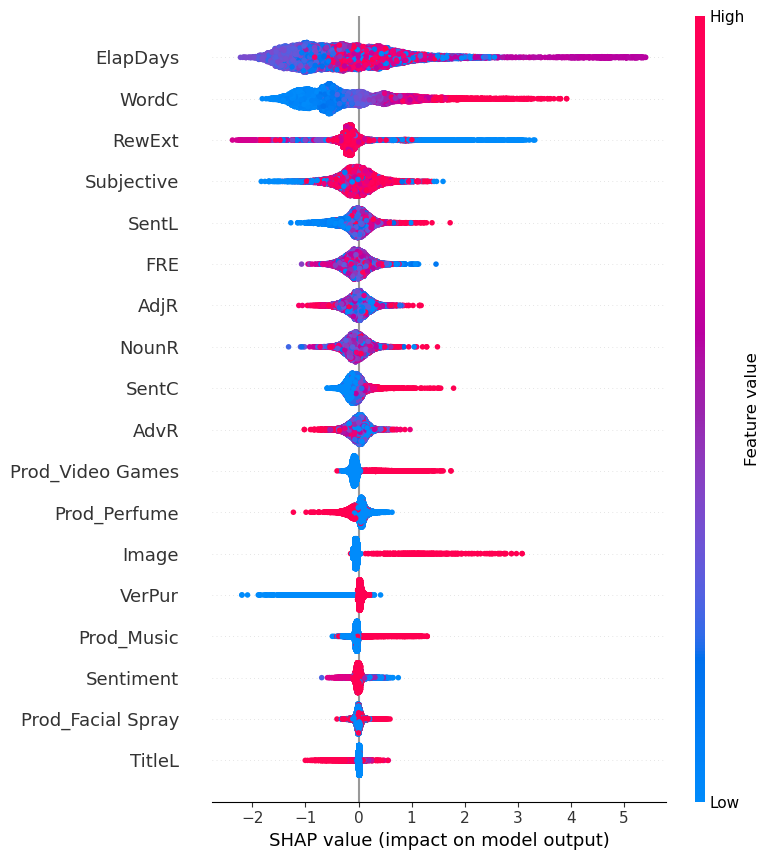

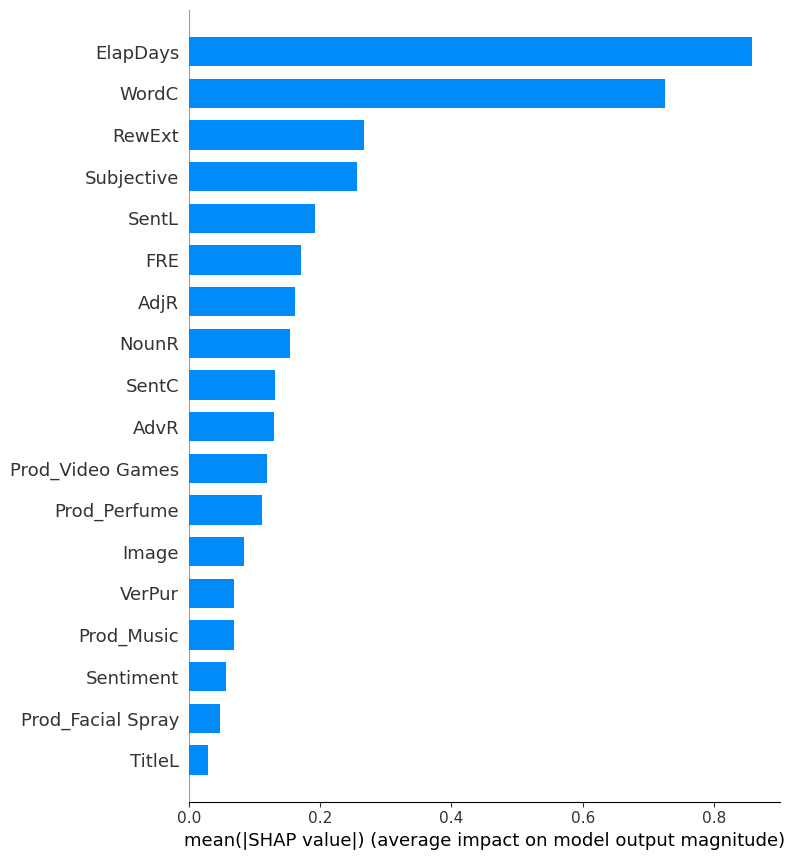

In [10]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_cls_default)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train)

# Create a beeswarm plot
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
plt.show()

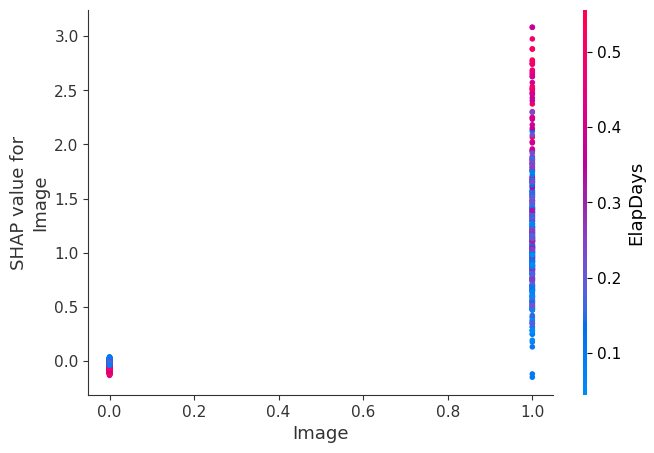

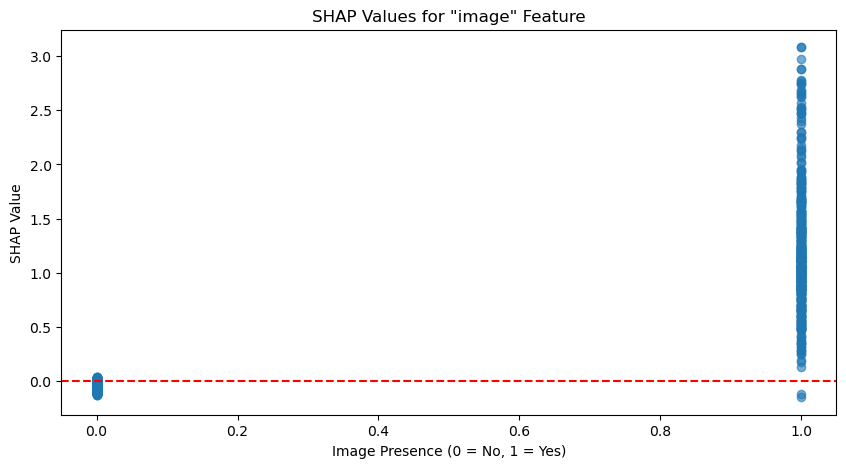

In [11]:
# Plot specifically for the 'image' feature
shap.dependence_plot('Image', shap_values, X_train)

# Extract SHAP values for the 'image' feature
image_shap_values = shap_values[:, X_train.columns.get_loc('Image')]

# Plot SHAP values for 'image'
plt.figure(figsize=(10, 5))
plt.scatter(X_train['Image'], image_shap_values, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('SHAP Values for "image" Feature')
plt.xlabel('Image Presence (0 = No, 1 = Yes)')
plt.ylabel('SHAP Value')
plt.show()


In [12]:
# Calculate the mean of the absolute SHAP values for each feature
average_shap_values_train = np.abs(shap_values).mean(axis=0)


In [13]:
# Create a DataFrame for the features and their average SHAP values
shap_df_train = pd.DataFrame({
    'features': X_train.columns,
    'average_shap_value': average_shap_values_train
})

# Sort the DataFrame based on the average SHAP values
shap_df_train_sorted = shap_df_train.sort_values(by='average_shap_value', ascending=False)

# Display the sorted DataFrame
print(shap_df_train_sorted)

             features  average_shap_value
11           ElapDays            0.857571
7               WordC            0.725885
4              RewExt            0.266694
6          Subjective            0.256044
9               SentL            0.191847
17                FRE            0.171184
15               AdjR            0.162325
14              NounR            0.154816
8               SentC            0.131421
16               AdvR            0.129125
3    Prod_Video Games            0.118695
2        Prod_Perfume            0.111487
12              Image            0.083823
13             VerPur            0.069270
1          Prod_Music            0.068898
5           Sentiment            0.056825
0   Prod_Facial Spray            0.047408
10             TitleL            0.029088


In [14]:
# Train model with SMOTE balanced data
xgb_cls_SMOTE = xgb.XGBClassifier()

xgb_cls_SMOTE.fit(X_train_balanced, y_train_balanced)

# Predictions on test data
y_pred_default = xgb_cls_SMOTE.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_default)
conf_matrix = confusion_matrix(y_test, y_pred_default)
cls_report = classification_report(y_test, y_pred_default)

print("\SMOTE Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_default)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_default)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_SMOTE, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)

\SMOTE Model Evaluation:
Accuracy: 0.8791788856304985
F1 Score: 0.5560344827586207
AUC: 0.7185062203806946
Confusion Matrix:
[[1370   69]
 [ 137  129]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1439
           1       0.65      0.48      0.56       266

    accuracy                           0.88      1705
   macro avg       0.78      0.72      0.74      1705
weighted avg       0.87      0.88      0.87      1705

Mean Cross-Validated Accuracy: 0.7326491646778044


# 3. Hyperparameter tuning

In [15]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], 
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train_balanced, y_train_balanced), ( X_test, y_test)]
    
    clf.fit(X_train_balanced, y_train_balanced,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [16]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

SCORE:                                                 
0.8604105571847507                                     
SCORE:                                                 
0.8598240469208212                                                                
  2%|▏         | 2/100 [00:00<00:08, 11.73trial/s, best loss: -0.8604105571847507]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.86158357771261                                                                  
SCORE:                                                                            
0.8592375366568915                                                              
SCORE:                                                                          
0.8604105571847507                                                              
SCORE:                                                                          
0.8586510263929619                                                              
SCORE:                                                                          
0.8580645161290322                                                              
  6%|▌         | 6/100 [00:00<00:05, 17.03trial/s, best loss: -0.86158357771261]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                          
0.8609970674486803                                                              
SCORE:                                                                          
0.8604105571847507                                                              
SCORE:                                                                          
0.8580645161290322                                                              
SCORE:                                                                          
0.8609970674486803                                                               
SCORE:                                                                           
0.8592375366568915                                                               
 11%|█         | 11/100 [00:00<00:04, 18.03trial/s, best loss: -0.86158357771261]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                           
0.8598240469208212                                                               
SCORE:                                                                           
0.8604105571847507                                                               
SCORE:                                                                           
0.8633431085043989                                                               
 14%|█▍        | 14/100 [00:00<00:05, 15.87trial/s, best loss: -0.86158357771261]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better

SCORE:                                                                           
0.8633431085043989                                                                 
SCORE:                                                                             
0.8598240469208212                                                                 
SCORE:                                                                             
0.8586510263929619                                                                 
SCORE:                                                                             
0.8604105571847507                                                                 
 18%|█▊        | 18/100 [00:01<00:05, 15.95trial/s, best loss: -0.8633431085043989]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8586510263929619                                                                 
SCORE:                                                                             
0.8633431085043989                                                                 
SCORE:                                                                             
0.8633431085043989                                                                 
 21%|██        | 21/100 [00:01<00:04, 17.27trial/s, best loss: -0.8633431085043989]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8627565982404692                                                                 
SCORE:                                                                             
0.8639296187683284                                                                 
SCORE:                                                                             
0.8609970674486803                                                                 
SCORE:                                                                             
0.8633431085043989                                                                 
 26%|██▌       | 26/100 [00:01<00:04, 17.18trial/s, best loss: -0.8639296187683284]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                             
0.8633431085043989                                                                 
SCORE:                                                                             
0.8621700879765396                                                                 
 28%|██▊       | 28/100 [00:01<00:04, 15.46trial/s, best loss: -0.8639296187683284]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8563049853372434                                                                 
SCORE:                                                                             
0.8633431085043989                                                                 
SCORE:                                                                             
0.8598240469208212                                                                 
SCORE:                                                                             
0.8633431085043989                                                                 
 32%|███▏      | 32/100 [00:01<00:03, 17.05trial/s, best loss: -0.8639296187683284]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8598240469208212                                                                 
SCORE:                                                                             
0.8592375366568915                                                                 
SCORE:                                                                             
0.8574780058651026                                                                 
 34%|███▍      | 34/100 [00:02<00:04, 15.12trial/s, best loss: -0.8639296187683284]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                             
0.8609970674486803                                                                 
SCORE:                                                                             
0.8598240469208212                                                                 
SCORE:                                                                             
0.8604105571847507                                                                 


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:
0.86158357771261                                                                   
SCORE:                                                                             
0.8609970674486803                                                                 
SCORE:                                                                             
0.8598240469208212                                                                 
SCORE:                                                                             
0.8633431085043989                                                                 
SCORE:                                                                             
0.8633431085043989                                                                 
 42%|████▏     | 42/100 [00:02<00:03, 16.78trial/s, best loss: -0.8639296187683284]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                             
0.8598240469208212                                                                 
SCORE:                                                                             
0.8598240469208212                                                                 
SCORE:                                                                             
0.8609970674486803                                                                 
 46%|████▌     | 46/100 [00:02<00:03, 16.25trial/s, best loss: -0.8639296187683284]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                             
0.8633431085043989                                                                 
SCORE:                                                                             
0.8586510263929619                                                                 
SCORE:                                                                             
0.8609970674486803                                                                 
 48%|████▊     | 48/100 [00:02<00:03, 17.09trial/s, best loss: -0.8639296187683284]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8651026392961877                                                                 
SCORE:                                                                             
0.8609970674486803                                                                 
SCORE:                                                                             
0.8604105571847507                                                                 
SCORE:                                                                             
0.8639296187683284                                                                 
SCORE:                                                                             
0.8651026392961877                                                                 
 54%|█████▍    | 54/100 [00:03<00:02, 16.93trial/s, best loss: -0.8651026392961877]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                             
0.8651026392961877                                                                 
SCORE:                                                                             
0.8604105571847507                                                                 
SCORE:                                                                             
0.8574780058651026                                                                 
 56%|█████▌    | 56/100 [00:03<00:02, 15.02trial/s, best loss: -0.8651026392961877]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                             
0.8604105571847507                                                                 
SCORE:                                                                             
0.8568914956011731                                                                 
SCORE:                                                                             
0.8639296187683284                                                                 
 60%|██████    | 60/100 [00:03<00:02, 16.67trial/s, best loss: -0.8651026392961877]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8598240469208212                                                                 
SCORE:                                                                             
0.8551319648093841                                                                 
SCORE:                                                                             
0.8633431085043989                                                                 
SCORE:                                                                             
0.8598240469208212                                                                 
SCORE:                                                                             
0.8604105571847507                                                                 
 64%|██████▍   | 64/100 [00:04<00:02, 15.91trial/s, best loss: -0.8651026392961877]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                             
0.8639296187683284                                                                 
SCORE:                                                                             
0.8651026392961877                                                                 
SCORE:                                                                             
0.8609970674486803                                                                 
 68%|██████▊   | 68/100 [00:04<00:02, 15.80trial/s, best loss: -0.8651026392961877]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                             
0.8574780058651026                                                                 
SCORE:                                                                             
0.8651026392961877                                                                 
SCORE:                                                                             
0.8639296187683284                                                                 
                                                                                   

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:
0.8574780058651026                                                                 
SCORE:                                                                             
0.8609970674486803                                                                 
SCORE:                                                                             
0.8639296187683284                                                                 
SCORE:                                                                             
0.8609970674486803                                                                 
SCORE:                                                                             


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

0.8639296187683284
SCORE:                                                                             
0.8598240469208212                                                                 
SCORE:                                                                             
0.8639296187683284                                                                 
SCORE:                                                                             
0.8639296187683284                                                                 
 78%|███████▊  | 78/100 [00:04<00:01, 14.65trial/s, best loss: -0.8651026392961877]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                             
0.864516129032258                                                                  
SCORE:                                                                             
0.8621700879765396                                                                 
SCORE:                                                                             
0.8551319648093841                                                                 
 82%|████████▏ | 82/100 [00:05<00:01, 14.28trial/s, best loss: -0.8651026392961877]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8609970674486803                                                                 
SCORE:                                                                             
0.8639296187683284                                                                 
SCORE:                                                                             
0.8604105571847507                                                                 
SCORE:                                                                             
0.8639296187683284                                                                 
 86%|████████▌ | 86/100 [00:05<00:00, 16.44trial/s, best loss: -0.8651026392961877]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8574780058651026                                                                 
SCORE:                                                                             
0.8627565982404692                                                                 
SCORE:                                                                             
0.8604105571847507                                                                 
SCORE:                                                                             
0.8639296187683284                                                                 
 89%|████████▉ | 89/100 [00:05<00:00, 14.82trial/s, best loss: -0.8651026392961877]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                             
0.8551319648093841                                                                 
SCORE:                                                                             
0.8609970674486803                                                                 
 92%|█████████▏| 92/100 [00:05<00:00, 14.52trial/s, best loss: -0.8651026392961877]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8609970674486803                                                                 
SCORE:                                                                             
0.8604105571847507                                                                 
SCORE:                                                                             
0.8551319648093841                                                                 
SCORE:                                                                             
0.8598240469208212                                                                 
 96%|█████████▌| 96/100 [00:06<00:00, 16.28trial/s, best loss: -0.8651026392961877]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8651026392961877                                                                 
SCORE:                                                                             
0.8639296187683284                                                                 
SCORE:                                                                             
0.8633431085043989                                                                 
 98%|█████████▊| 98/100 [00:06<00:00, 14.38trial/s, best loss: -0.8651026392961877]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibi

SCORE:                                                                             
0.8598240469208212                                                                 
100%|██████████| 100/100 [00:06<00:00, 15.83trial/s, best loss: -0.8651026392961877]
The best hyperparameters are :  

{'colsample_bytree': 0.8481612939526808, 'gamma': 8.369481067285026, 'max_depth': 7.0, 'min_child_weight': 6.0, 'reg_alpha': 173.0, 'reg_lambda': 0.9065456004916367}


In [17]:
best_hyperparams={'colsample_bytree': 0.6912196339708366, 'gamma': 7.933913866056239, 'max_depth': 12, 'min_child_weight': 6.0, 'reg_alpha': 47.0, 'reg_lambda': 0.9319510603930535}




In [18]:
# Train model with default hyperparameters
xgb_cls_hyp = xgb.XGBClassifier(**best_hyperparams)

xgb_cls_hyp.fit(X_train, y_train)

# Predictions on test data
y_pred_opt = xgb_cls_hyp.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_default)
conf_matrix = confusion_matrix(y_test, y_pred_default)
cls_report = classification_report(y_test, y_pred_default)

print("\nDefault Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_default)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_default)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_hyp, X_train, y_train, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)


Default Model Evaluation:
Accuracy: 0.8791788856304985
F1 Score: 0.5560344827586207
AUC: 0.7185062203806946
Confusion Matrix:
[[1370   69]
 [ 137  129]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1439
           1       0.65      0.48      0.56       266

    accuracy                           0.88      1705
   macro avg       0.78      0.72      0.74      1705
weighted avg       0.87      0.88      0.87      1705

Mean Cross-Validated Accuracy: 0.7868532121679122


[15:06:11] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


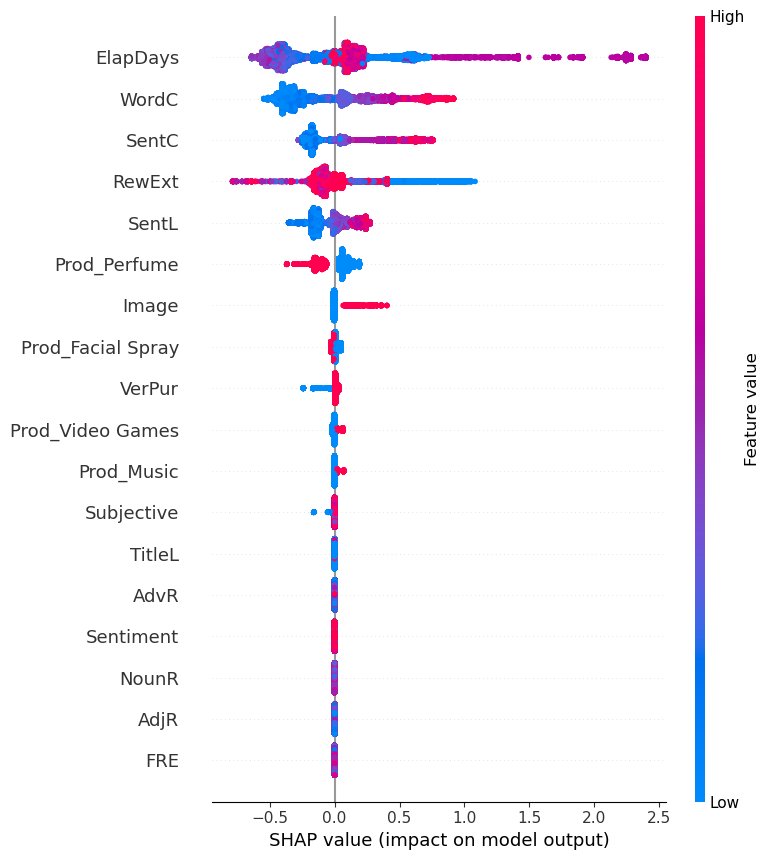

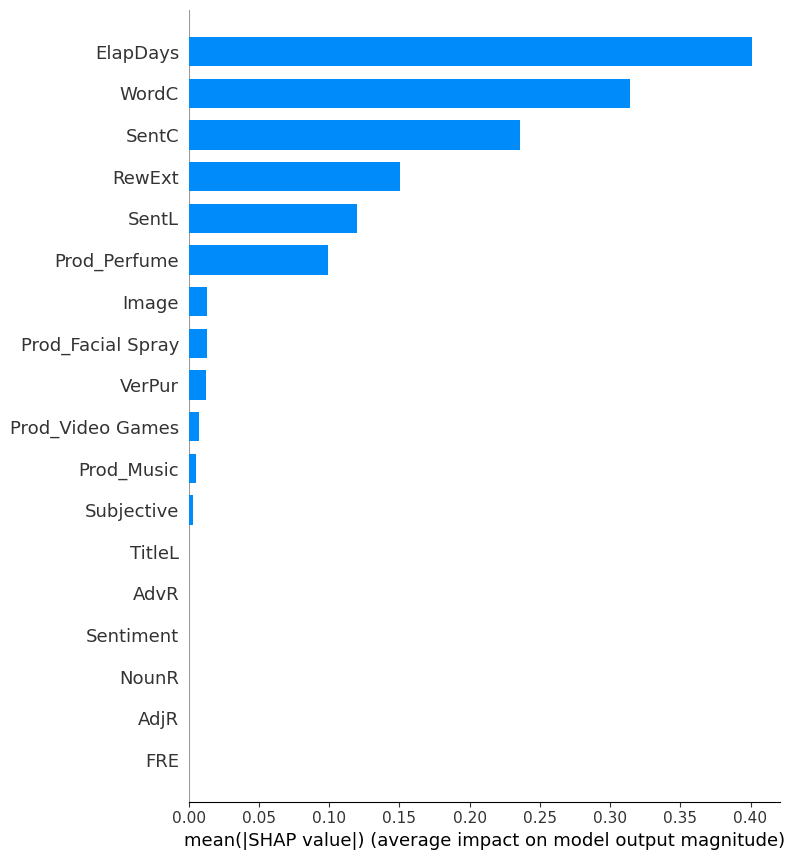

In [19]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_cls_hyp)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train_balanced)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train_balanced)

# Create a beeswarm plot
shap.summary_plot(shap_values, X_train_balanced, plot_type="bar", show=False)
plt.show()


[15:06:13] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


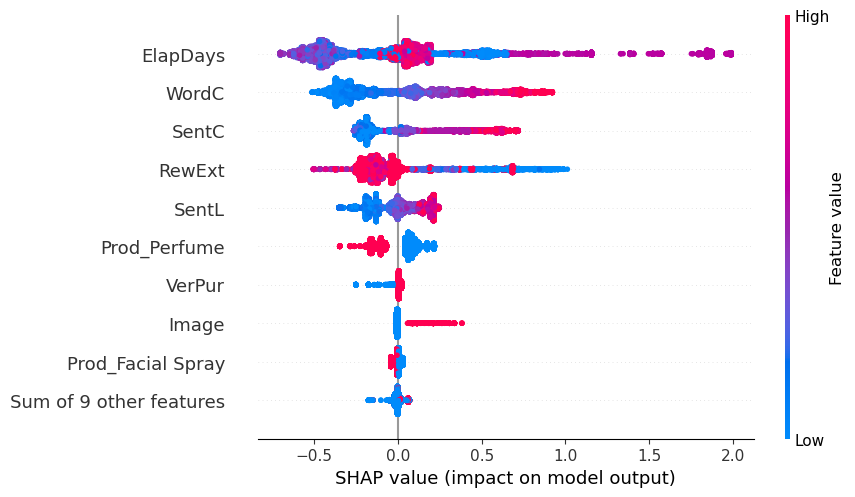

In [20]:
# compute SHAP values
explainer = shap.Explainer(xgb_cls_hyp, X_train_balanced)
shap_values = explainer(X_train_balanced)

shap.plots.beeswarm(shap_values, max_display=10)


[15:06:18] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


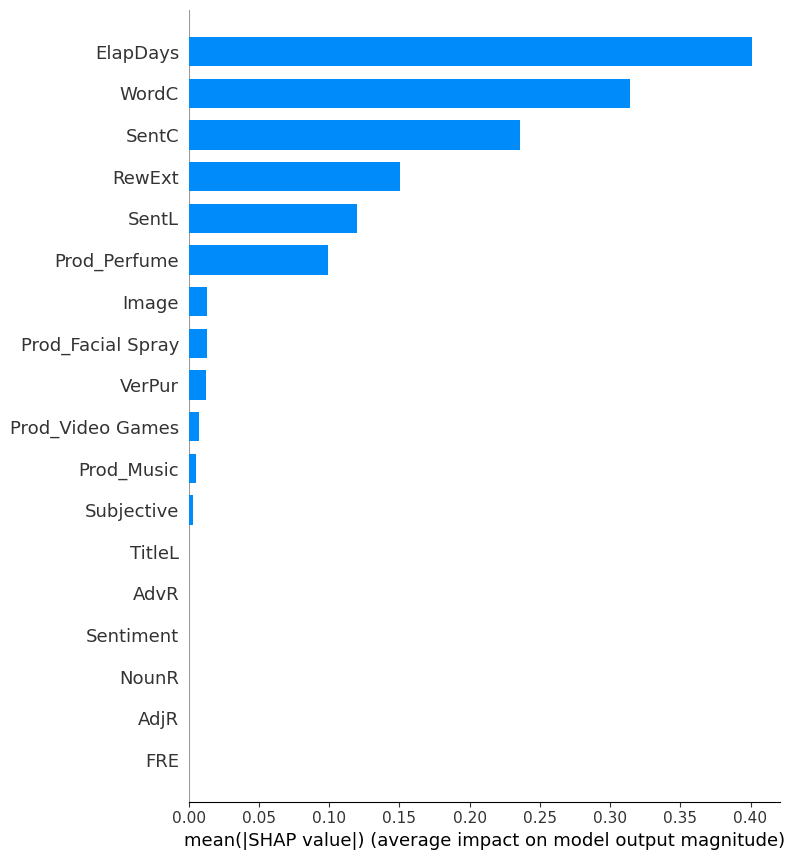

In [21]:
import matplotlib.pyplot as plt
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_cls_hyp)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train_balanced)

# Plot the SHAP summary plot with beeswarm plot
shap.summary_plot(shap_values, X_train_balanced, plot_type="bar", show=True)


[15:06:18] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


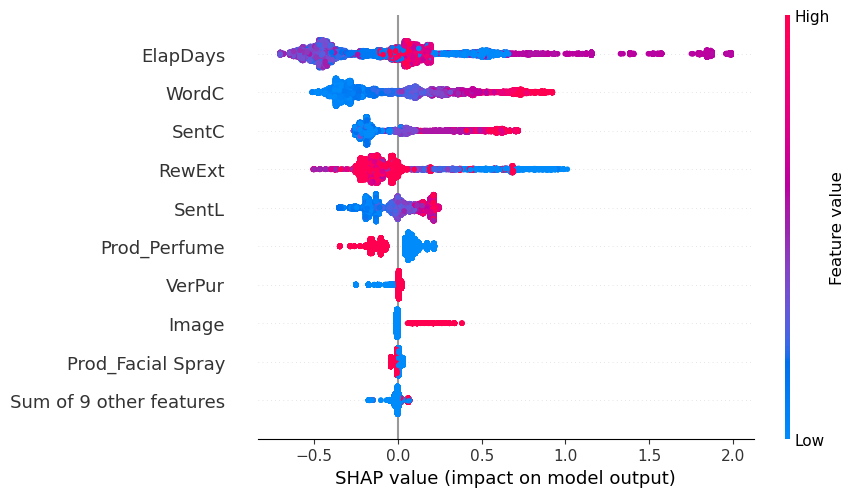

In [22]:
# compute SHAP values
explainer = shap.TreeExplainer(xgb_cls_hyp, X_train_balanced)
shap_values = explainer(X_train_balanced)

shap.plots.beeswarm(shap_values, max_display=10)